In [1]:
library(velocyto.R)
library(ggplot2)
source("../R/Seurat_functions.R")

Loading required package: Matrix


# 6.1 load seurat

In [2]:
lnames = load(file = "../data/DLBCL_8.Rda")
lnames

[1] "DLBCL"     "genes.use"

In [3]:
AllCells <- Seurat::WhichCells(DLBCL)
Cells_3119T6 <- AllCells[grepl("3119T6",AllCells)]
DLBCL_3119T6 <- Seurat::SubsetData(DLBCL, cells.use = Cells_3119T6)
DLBCL_3119T6

An object of class seurat in project EC-RW-4311 EC-RW-4311 EC-RW-4311 EC-RW-4311 EC-RW-4262 EC-RW-4262 EC-RW-4311 EC-RW-4311 
 20809 genes across 8582 samples.

# 6.2 Rename identities

In [4]:
idents <- as.data.frame(table(DLBCL_3119T6@ident))
old.ident.ids <- idents$Var1
old.ident.ids

[1] 0  1  2  3  4  5  6  7  8  9  10 11 12
Levels: 0 1 2 3 4 5 6 7 8 9 10 11 12

In [5]:
new.cluster.ids <- c("B cells",
                     "B cells",
                     "B cells",
                     "B cells",
                     "B cells",
                     "B cells",
                     "B cells",
                     "B cells",
                     "B cells",
                     "B cells",
                     "B cells",
                     "T & NK cells",
                     "B cells")
DLBCL_3119T6@ident <- plyr::mapvalues(x = DLBCL_3119T6@ident,
                                   from = old.ident.ids,
                                   to = new.cluster.ids)

# 6.3 Extract color code and TSNE embeddings

      colour
1    #F8766D
4315 #00BFC4


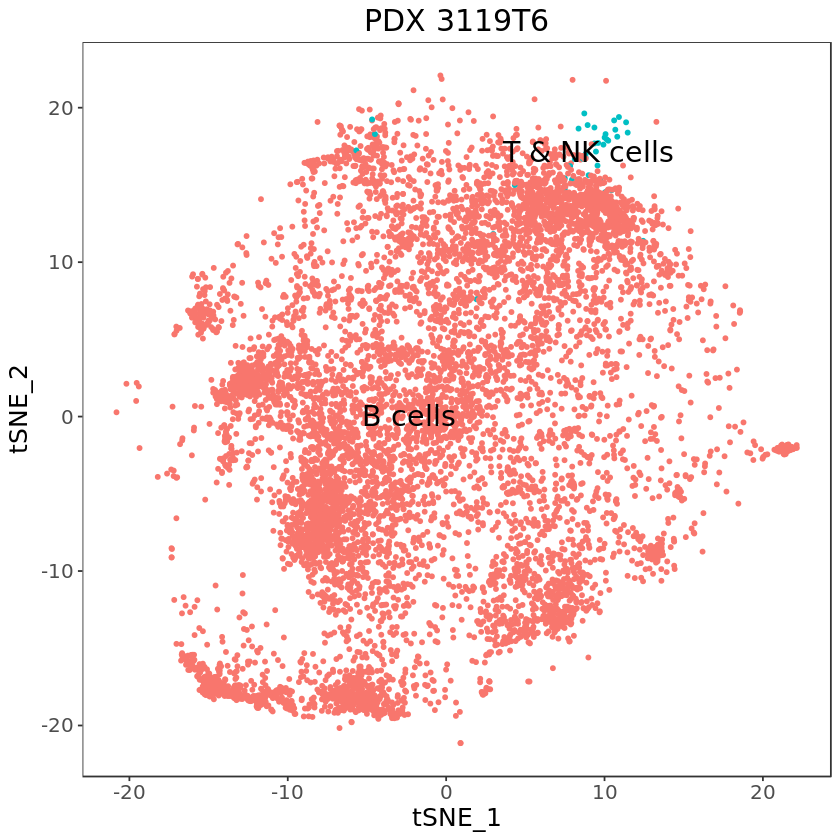

In [6]:
gg_colors <- function(object = object, no.legend = TRUE, do.label = TRUE,
                      do.return = TRUE, label.size = 6, gg_title=""){
        g1 <- Seurat::TSNEPlot(object = object, no.legend = no.legend,
                               do.label = do.label,do.return = do.return,
                               label.size = label.size)+
                ggtitle(gg_title)+
                theme(text = element_text(size=15),     #larger text including legend title							
                      plot.title = element_text(hjust = 0.5)) #title in middle
        print(g1)
        g <- ggplot2::ggplot_build(g1)
        print(unique(g$data[[1]]["colour"]))
        colors <- unlist(g$data[[1]]["colour"])
        cells <- Seurat::WhichCells(object)
        names(colors) <- stringi::stri_replace_last_fixed(cells,"_",":")
        names(colors) <- paste0(names(colors),"x")
        
        return(colors)
}
Colors_3119T6 <- gg_colors(object = DLBCL_3119T6, gg_title="PDX 3119T6")

In [7]:
DLBCL_3119T6_emb <- DLBCL_3119T6@dr$tsne@cell.embeddings[,1:2]
row.names(DLBCL_3119T6_emb) <- stringi::stri_replace_last_fixed(row.names(DLBCL_3119T6_emb),"_",":")
row.names(DLBCL_3119T6_emb) <- paste0(row.names(DLBCL_3119T6_emb),"x")
remove(DLBCL)
remove(DLBCL_3119T6)
GC() # Clean memory

# 6.4 load loom file

In [8]:
ldat  <- read.loom.matrices("../data/3119T6/velocyto/3119T6.loom")
cell.colors <- Colors_3119T6
emb <- DLBCL_3119T6_emb

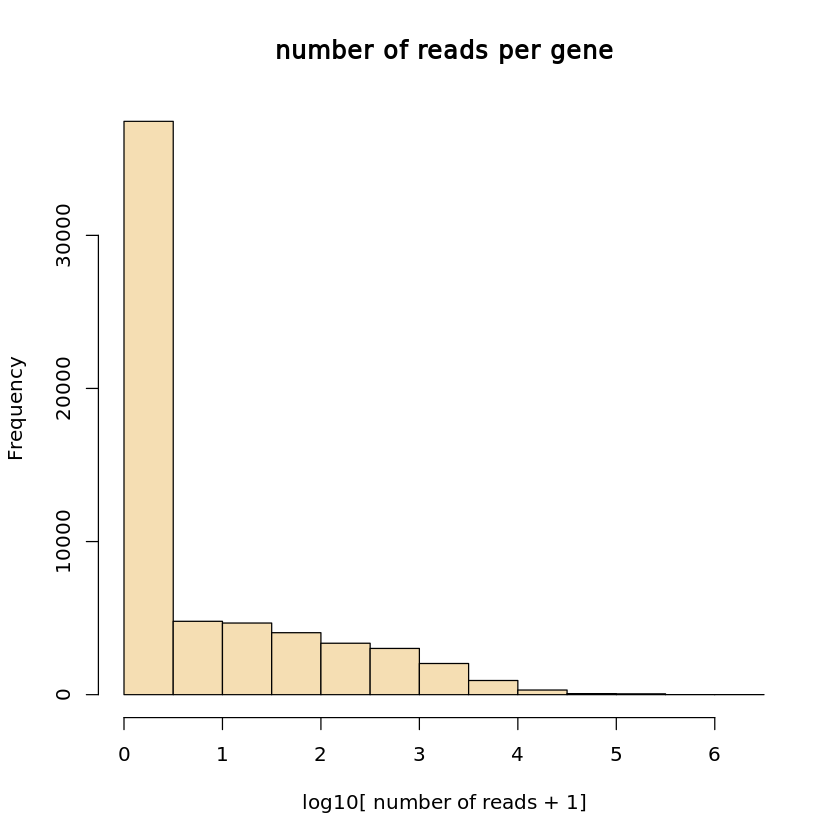

In [9]:
hist(log10(rowSums(ldat$spliced)+1),col='wheat',xlab='log10[ number of reads + 1]',
     main='number of reads per gene')

In [10]:
emat <- ldat$spliced # exonic read (spliced) expression matrix
nmat <- ldat$unspliced # intronic read (unspliced) expression matrix
smat <- ldat$ambiguous # spanning read (intron+exon) expression matrix
str(emat@Dim);str(nmat@Dim);str(smat@Dim)

 int [1:2] 60736 8583
 int [1:2] 60736 8583
 int [1:2] 60736 8583


In [14]:
# filter expression matrices based on some minimum max-cluster averages
emat <- filter.genes.by.cluster.expression(emat,cell.colors,min.max.cluster.average = 0.4)
nmat <- filter.genes.by.cluster.expression(nmat,cell.colors,min.max.cluster.average = 0.4)
smat <- filter.genes.by.cluster.expression(smat,cell.colors,min.max.cluster.average = 0.05)
str(emat@Dim);str(nmat@Dim);str(smat@Dim)
# look at the resulting gene set
str(intersect(intersect(rownames(emat),rownames(nmat)),rownames(smat)))

 int [1:2] 1315 8583
 int [1:2] 2164 8583
 int [1:2] 1482 8583
 chr [1:152] "hg19_HP1BP3" "hg19_TXNDC12" "hg19_TPM3" "hg19_RP11-144L1.4" ...


# 6.5 calculate gene-relative velocity

using k=5 cell kNN pooling, but now using entire range of expression to determine slope gamma,
and using spanning reads (smat) to fit the gene offsets.

In [11]:
rvel.qf <- gene.relative.velocity.estimates(emat,nmat,deltaT=1,kCells = 5,fit.quantile = 0.02)

In [ ]:
pca.velocity.plot(rvel.qf,nPcs=5,plot.cols=2,cell.colors=ac(colors,alpha=0.7),
                  cex=1.2,pcount=0.1,pc.multipliers=c(1,-1,-1,-1,-1))

In [ ]:
rvel <- gene.relative.velocity.estimates(emat,nmat,smat=smat,deltaT=1,kCells = 5, 
                                         min.nmat.emat.slope = 0.1, min.nmat.smat.correlation = 0.1)

# 6.6 define custom pallet for expression magnitude

In [ ]:
gene.relative.velocity.estimates(emat,nmat,deltaT=1,kCells = 5,fit.quantile = 0.02,old.fit=rvel.qf,
                                 show.gene='hg19_SAT1',cell.emb=emb,cell.colors=cell.colors)

# 6.7 Visualization on an existing embedding

In [ ]:
arrow.scale=6; cell.alpha=0.4; cell.cex=1; fig.height=4; fig.width=4.5;
show.velocity.on.embedding.cor(emb,rvel.qf,n=100,scale='sqrt',cell.colors=ac(cell.colors,alpha=cell.alpha),
                               cex=cell.cex,arrow.scale=arrow.scale,arrow.lwd=1)

Alternatively, the same function can be used to calculate a velocity vector field:

In [ ]:
show.velocity.on.embedding.cor(emb,rvel.qf,n=100,scale='sqrt',cell.colors=ac(cell.colors,alpha=cell.alpha),
                               cex=cell.cex,arrow.scale=arrow.scale,show.grid.flow=TRUE,min.grid.cell.mass=0.5,
                               grid.n=20,arrow.lwd=2)